# Благотворительный фонд “Бюро добрых дел”

### Часть 2. ML


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #масштабирование признаков

from sklearn.metrics import confusion_matrix
import seaborn

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize

warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('masterskaya_id_info.csv')

In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
df.head()

,id,gender,city_category,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,2020-12-30 11:42:20,2022-07-03 19:49:48,21,3500.0,166.666667,100.0,73.080738,...,43.098897,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
1,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,2019-10-11 09:03:12,2022-04-29 17:18:36,11,4200.0,381.818182,400.0,28.203597,...,108.203897,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,мужской,Город неизвестен,2022-04-07 00:00:00,2022-07-07 00:00:00,3,63.0,21.000000,16.0,0.000000,...,39.925147,0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
3,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,женский,Город неизвестен,2020-12-26 01:25:32,2022-07-26 01:25:45,18,3600.0,200.000000,200.0,26.069164,...,20.865599,2,400.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
4,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,женский,Город неизвестен,2017-08-26 18:16:27,2019-03-26 18:20:06,18,1800.0,100.000000,100.0,28.237902,...,1238.161189,2,200.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0


In [9]:
# удалим столбцы, которые не понадобятся для дальнейшей работы
df = df.drop(['first_date', 'last_date'], axis=1)

In [10]:
df.columns.to_frame()

,0
id,id
gender,gender
city_category,city_category
donations_count,donations_count
donations_sum,donations_sum
donations_mean,donations_mean
donations_median,donations_median
last_email_activity,last_email_activity
is_reccurent,is_reccurent
lifetime,lifetime


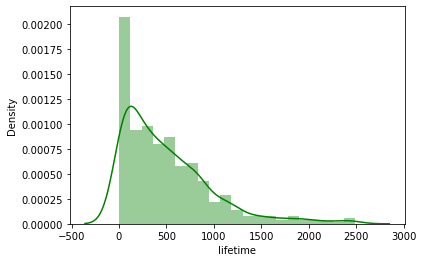

In [11]:
sns.distplot(df['lifetime'], color='green');

<AxesSubplot:>

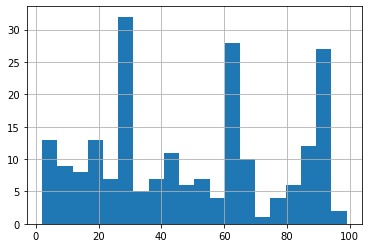

In [12]:
df[df['lifetime']<100]['lifetime'].hist(bins=20)

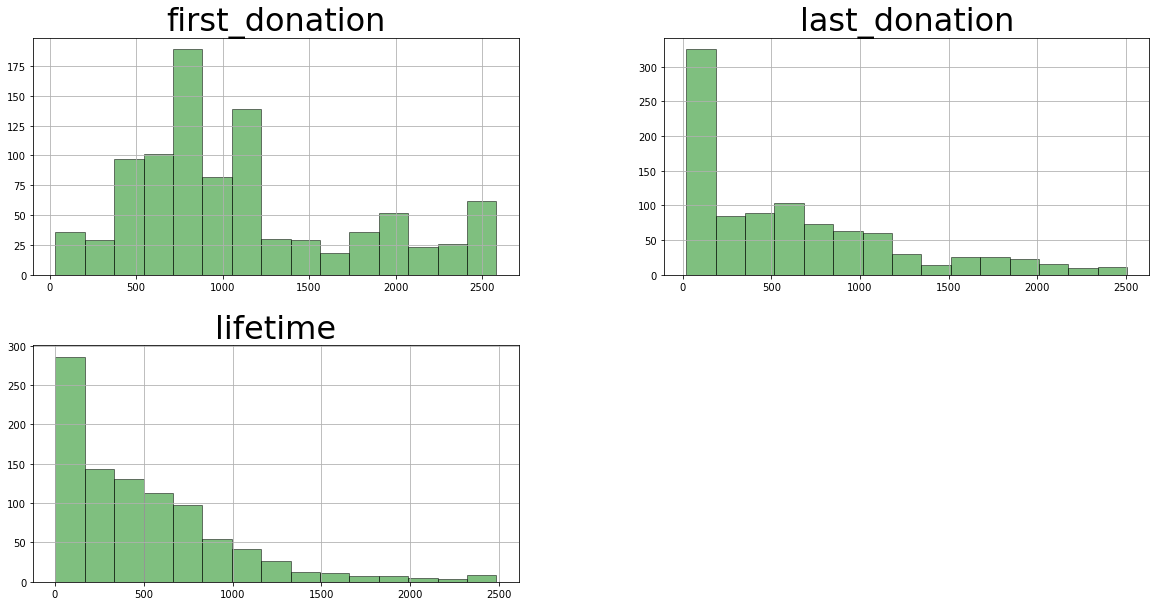

In [13]:
fig = df[['first_donation','last_donation', 'lifetime']].hist(alpha=0.5, figsize=(20,10), bins=15, fc='green',ec="black");
[x.title.set_size(32) for x in fig.ravel()];


## Подготовка датасета для ML


### Целевые признаки:

count_lt_diff - разность между количеством платежей за первое и последнее полугодие

total_lt_diff - разность между общей суммой пожертвований за первое и последнее полугодие

### Краткое исследование значений в  count_lt_diff и total_lt_diff

In [14]:
df[['count_lt_diff', 'total_lt_diff']].describe()

,count_lt_diff,total_lt_diff
count,949.000000,949.000000
mean,0.142255,176.566249
std,2.027187,5320.243406
min,-15.000000,-44000.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,200.000000
max,10.000000,60000.000000


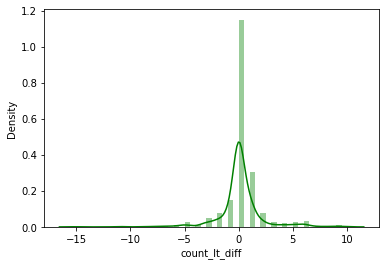

In [15]:
sns.distplot(df['count_lt_diff'], color='green');

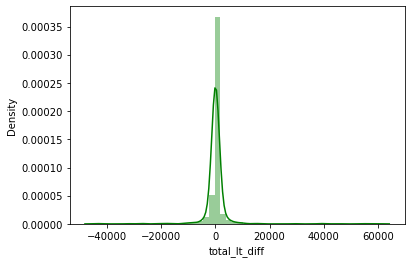

In [16]:
sns.distplot(df['total_lt_diff'], color='green')
sns.figsize = (100,100);
sns.xlim = (-2000,2000)

In [17]:
len(df['count_lt_diff'].unique())

22

In [18]:
len(df['total_lt_diff'].unique())

157

In [19]:
df['total_lt_diff'].value_counts().to_frame().head(10)

,total_lt_diff
0.0,445
500.0,34
-500.0,31
1000.0,29
100.0,26
300.0,23
-200.0,21
200.0,19
-100.0,19
-1000.0,14


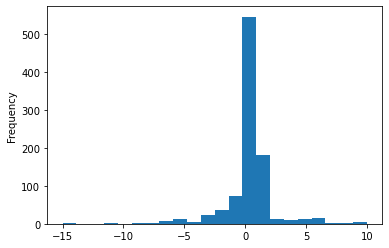

In [20]:
df['count_lt_diff'].plot(kind='hist', bins=22);

In [21]:
df['total_lt_diff'].describe().to_frame()

,total_lt_diff
count,949.000000
mean,176.566249
std,5320.243406
min,-44000.000000
25%,0.000000
50%,0.000000
75%,200.000000
max,60000.000000


## Подготовка датасета для ML

In [22]:
# классифицируем значения в столбце 'count_lt_diff'(разность между количеством пожертвований за первое и последнее полугодия lifetime)
# Значения :
# 0: -2 до 2 без изменений
# 1: >2 частота платежей увеличилась
# 3: <2  частота платежей уменьшилась
df['count_class'] = df['count_lt_diff'].apply(lambda x: 0 if ((x >= -2) and (x <= 2)) else(1 if x > 2 else -1))

# классифицируем значения в столбце 'total_lt_diff'(разность между общей суммой пожертвований за первое и последнее полугодия lifetime)
# Значения :
# 0: -200 до 200 без изменений
# 1: >200 сумма платежей увеличилась
# 3: <200  сумма платежей уменьшилась
#df['count_class'] = df['count_lt_diff'].apply(lambda x: 0 if ((x > -2) and (x < 2)) else(1 if x > 2 else -1))
df['total_class'] = df['total_lt_diff'].apply(lambda x: 0 if ((x >= -200) and (x <= 200)) else (1 if x >200 else -1))

df.head(2)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,count_class,total_class
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,21,3500.0,166.666667,100.0,73.080738,1,550.0,...,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,1
1,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,11,4200.0,381.818182,400.0,28.203597,0,931.0,...,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0,0,1


In [23]:
# процент лучших показателей (лучшие 11)
df[(df['total_class']==1) & (df['count_class']==1)]['id'].count()/df['id'].count()

0.05374077976817703

In [24]:
# количество лучших не ушедших жертвователей (последний платеж до полугода назад)
df[(df['total_class']==1) & (df['count_class']==1) & (df['last_donation']<182)]['id'].count()

42

In [25]:
#добавим столбец с целевым признаком
df['class'] = df.count_class.map(str)\
+ df.total_class.map(str)

#удалим лишние столбцы
df = df.drop(['total_class', 'count_class'], axis=1)

df.sample(5)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
664,209A4193-D2D0-463E-9B49-95346DBF414E,женский,Москва,6,3899.97,649.995000,649.995,28.201120,0,587.0,...,1,999.99,0.833333,0.000000,0.0,0.166667,1.000000,0.000000,0.0,01
170,D5F6D6F5-34E7-4D39-9F61-D6932241D0DA,женский,Другие города России,21,9600.00,457.142857,500.000,20.940541,1,1155.0,...,2,1600.00,0.761905,0.095238,0.0,0.142857,0.761905,0.238095,0.0,01
138,9BEB3436-0E1C-4398-A73A-3925686E7F09,женский,Другие города России,5,1500.00,300.000000,300.000,430.368388,1,122.0,...,0,0.00,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,00
649,D52A7DF6-3241-458B-AC07-870A83032DC6,женский,Москва,6,90000.00,15000.000000,7500.000,28.237798,0,364.0,...,0,60000.00,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,01
11,F836F738-FB7E-4134-ABA8-B6E9CA1E71EA,женский,Другие города России,76,2280.00,30.000000,30.000,0.000000,0,581.0,...,-2,-60.00,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.0,00


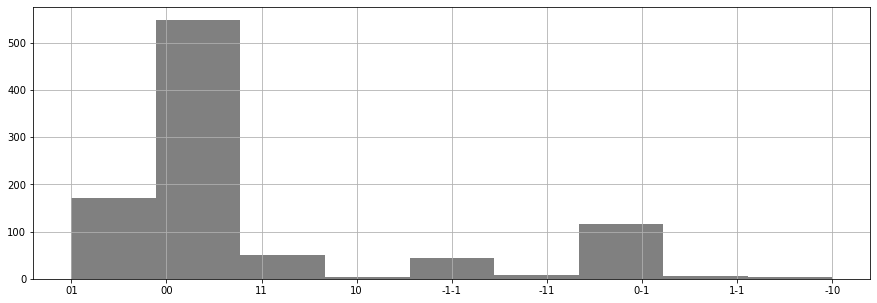

In [26]:
df['class'].hist(bins=9, figsize = (15,5), color='gray');

In [27]:
df['class'].unique()

array(['01', '00', '11', '10', '-1-1', '-11', '0-1', '1-1', '-10'],
      dtype=object)

In [28]:
df[df['class']=='-11']

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
37,E85E70D9-6809-4E1C-AE25-0EC489934DDC,мужской,Москва,34,4300.0,126.470588,100.0,28.237775,1,1813.0,...,-3,600.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
134,193FBEF8-9C3E-4581-BBDF-A5D3EF653AE1,мужской,Москва,62,34500.0,556.451613,500.0,28.237798,1,2009.0,...,-3,500.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
164,07923DBB-392D-4448-8117-E769F52AA476,женский,Город неизвестен,34,20300.0,597.058824,300.0,28.237763,1,1342.0,...,-3,9200.0,0.970588,0.0,0.029412,0.000000,1.000000,0.0,0.000000,-11
179,22BDC942-B82B-4004-ADFC-7787F780FB60,мужской,Москва,8,2125.0,265.625000,100.0,28.237775,1,551.0,...,-4,525.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
226,64AE2C89-F75D-46C4-811C-CF199C3A43C9,женский,Другие города России,33,8300.0,251.515152,200.0,27.838608,1,2397.0,...,-4,800.0,0.969697,0.0,0.000000,0.030303,0.969697,0.0,0.030303,-11
234,69613503-5B71-4690-ACB5-8E783FF915B4,мужской,Город неизвестен,23,15500.0,673.913043,500.0,0.000000,0,462.0,...,-3,1500.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,-11
654,214CC544-A5CE-4E6E-B3BD-B2CC5396C5A0,женский,Город неизвестен,13,26500.0,2038.461538,1000.0,28.237775,1,1010.0,...,-5,8500.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11


In [29]:
# разобьем жертвователей на 4 класса
# - 1 -- уменьшившие сумму и/или частоту пожертвований;
# 0 -- не изменившие сумму и частоту пожертвований;
# 1 -- увеличившие сумму или частоту пожертвований;
# 2 -- увеличившие сумму и частоту пожертвований

df['class'] = df['class'].replace(['11'],2)
df['class'] = df['class'].replace(['01','10','-11','1-1'],1)
df['class'] = df['class'].replace('00', 0)
df['class'] = df['class'].replace(['-1-1','-10','0-1'],-1)
df['class'].unique()

array([ 1,  0,  2, -1])

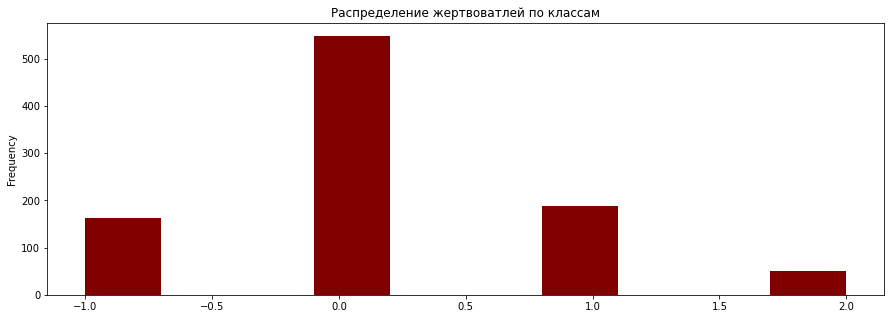

In [30]:
df['class'].plot(title='Распределение жертвоватлей по классам', kind='hist', figsize=(15,5), color='maroon');

In [31]:
df['class'].value_counts().to_frame()

,class
0,548
1,188
-1,162
2,51


## Подготовим выборки для ML

## Кодирование

In [32]:
df.columns

Index(['id', 'gender', 'city_category', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'lifetime', 'period', 'first_donation', 'last_donation',
       'count_lt_diff', 'total_lt_diff', 'пожертвование', 'sms_purpose',
       'именное пожертвование', 'назнчение не указано', 'банковские карты',
       'sms_channel', 'прямые поступления на счет', 'class'],
      dtype='object')

In [33]:
columns = ['is_reccurent', 
       'gender', 
       'city_category']

for i in columns:
    df[i] = (df[i]).astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          949 non-null    object  
 1   gender                      949 non-null    category
 2   city_category               949 non-null    category
 3   donations_count             949 non-null    int64   
 4   donations_sum               949 non-null    float64 
 5   donations_mean              949 non-null    float64 
 6   donations_median            949 non-null    float64 
 7   last_email_activity         949 non-null    float64 
 8   is_reccurent                949 non-null    category
 9   lifetime                    949 non-null    float64 
 10  period                      949 non-null    float64 
 11  first_donation              949 non-null    float64 
 12  last_donation               949 non-null    float64 
 13  count_lt_diff       

In [34]:
for i in columns:
    df[i] = (df[i]).cat.codes

df.head(2)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
0,DE5393F9-9585-4057-B7FB-24B69697FC08,1,3,21,3500.0,166.666667,100.0,73.080738,1,550.0,...,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,1
1,81CD4BEF-443E-4D36-B34F-664E11182D65,1,3,11,4200.0,381.818182,400.0,28.203597,0,931.0,...,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0,1


In [35]:
df = df.drop(['id', 'total_lt_diff','count_lt_diff'], axis=1)

### Новые жертвователи
Условия:
* первый платеж совершен от полугода до года назад.

Для этих пользователей предскажем дальнейшее поведение.

In [36]:
# выделим из датасета новых жертвователей (первый платеж от полугода до года назад)
df_new = df[(df['first_donation']>=182) & (df['first_donation']<=365)]
# удалим столбец с целевым признаком ('class'), предварительно сохранив его
class_new = df_new['class']
df_new = df_new.drop('class',axis=1)
print('Доля новых жертвователей: ', len(df_new['first_donation'])/len(df['first_donation']))
df_new.sample(3)

Доля новых жертвователей:  0.03161222339304531


,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
200,1,1,9,4500.0,500.0,500.0,24.343608,1,242.0,26.888889,283.335657,41.335564,1.0,0.0,0.0,0.0,1.0,0.0,0.0
86,0,3,4,9000.0,2250.0,2500.0,280.114557,0,19.0,4.750000,316.542752,297.431548,1.0,0.0,0.0,0.0,1.0,0.0,0.0
876,2,3,2,1000.0,500.0,500.0,27.616756,1,61.0,30.500000,334.383573,273.383434,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
df_new.describe()

,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,1.000000,1.400000,5.233333,4166.033333,661.921789,647.433333,24.808263,0.300000,161.733333,35.816609,289.253406,127.325478,0.851515,0.012121,0.0,0.136364,0.587879,0.012121,0.400000
std,0.643268,1.302517,3.318530,8341.454866,931.497631,950.403750,50.072459,0.466092,103.674202,29.382898,48.989612,103.501033,0.346364,0.066391,0.0,0.344934,0.492597,0.066391,0.498273
min,0.000000,0.000000,2.000000,60.000000,10.000000,10.000000,0.000000,0.000000,13.000000,4.750000,185.925147,20.365541,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,731.250000,276.136364,300.000000,0.000000,0.000000,56.500000,23.550000,263.675147,41.732960,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.000000,1600.000000,420.000000,400.000000,25.644256,0.000000,192.000000,27.400000,295.824279,90.701571,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,8.750000,3750.000000,731.250000,612.500000,28.237786,1.000000,255.500000,42.807143,330.923559,203.046097,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000
max,2.000000,3.000000,11.000000,45000.000000,5000.000000,5000.000000,280.114557,1.000000,305.000000,130.000000,363.960738,330.925147,1.000000,0.363636,0.0,1.000000,1.000000,0.363636,1.000000


In [38]:
# удалим новых жертвователей из основного датасета
df = df[df['first_donation']>365]

In [39]:
# разделим данные на выборки
target = df['class']
features = df.drop('class', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=12345)

In [40]:
features_names = features.columns

In [41]:
from sklearn.metrics import roc_curve, auc

In [42]:
features_names.to_frame()

,0
gender,gender
city_category,city_category
donations_count,donations_count
donations_sum,donations_sum
donations_mean,donations_mean
donations_median,donations_median
last_email_activity,last_email_activity
is_reccurent,is_reccurent
lifetime,lifetime
period,period


In [43]:
# функция для вычисления метрик
def accuracy(model):
    predictions = model.predict(features_test)
    print('Accuracy:', accuracy_score(predictions, target_test))
    
    # confusion_matrix
    confusion_matrix_ = pd.DataFrame(confusion_matrix(predictions, target_test)/len(target_test), columns=[-1,0,1,2], index=[-1,0,1,2])
    seaborn.heatmap(confusion_matrix_, annot=True, square=True)
    sns.set(rc = {'figure.figsize':(10,10)})
    plt.title('Матрица ошибок на тестовой выборке', y=1.05, fontsize=22)
    plt.ylabel('Предсказания', fontsize=12)
    plt.xlabel('Вычисленные значения', fontsize=12);
    plt.show();
   # roc auc
    predict_proba = model.predict_proba(features_test)
    predict_proba1 = predict_proba[:, 1]
   # predict_proba = np.array(predict_proba)
    print('ROC AUC:', roc_auc_score(target_test, predict_proba, multi_class="ovr"))
    
    # основные метрики при помощи classification_report
    print(classification_report(predictions, target_test))

### CatBoost

In [44]:
%%time
model1_grid = CatBoostClassifier(random_state = 12345, verbose=0)

parameters = {'depth': [5, 10],
                 'learning_rate': [0.02,0.04],
                  'iterations': [50, 100]
                 }

grid = GridSearchCV(estimator=model1_grid, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)

{'depth': 5, 'iterations': 100, 'learning_rate': 0.04}
0.6638418079096045
CPU times: user 776 ms, sys: 117 ms, total: 892 ms
Wall time: 31.4 s


Accuracy: 0.6440677966101694


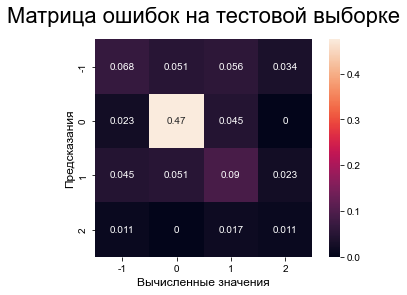

ROC AUC: 0.8481932274637768
              precision    recall  f1-score   support

          -1       0.46      0.32      0.38        37
           0       0.82      0.88      0.85        96
           1       0.43      0.43      0.43        37
           2       0.17      0.29      0.21         7

    accuracy                           0.64       177
   macro avg       0.47      0.48      0.47       177
weighted avg       0.64      0.64      0.64       177



In [45]:
# CatBoost

#выделим категориальные признаки для бустинга
cat_features = ['is_reccurent',  'gender']

model1 = CatBoostClassifier(iterations=150, random_state = 12345)
model1.fit(features_train, target_train, cat_features=cat_features, verbose=0)
accuracy(model1)

### RandomForest

In [46]:
%%time
model_2_grid = RandomForestClassifier()

parametrs = {'n_estimators': range (1,20,2),
              'max_depth': range (2,20,2),
              }

grid = GridSearchCV(model_2_grid, parametrs, cv=5, scoring='accuracy')
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 14, 'n_estimators': 19}
0.690630306662671
CPU times: user 11.1 s, sys: 168 ms, total: 11.3 s
Wall time: 11.4 s


Accuracy: 0.672316384180791


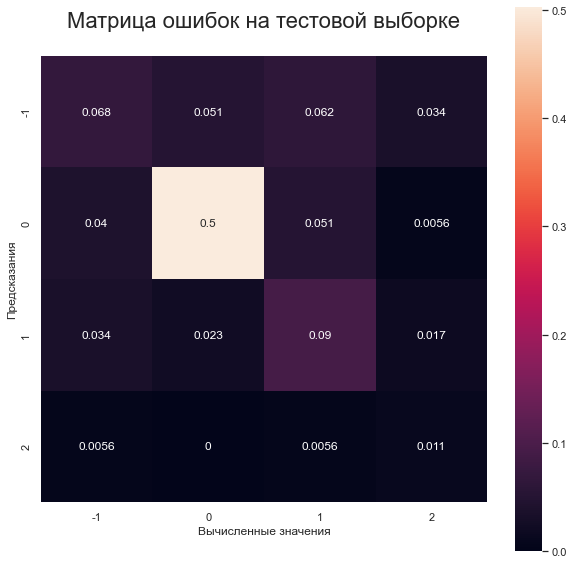

ROC AUC: 0.8546085802007111
              precision    recall  f1-score   support

          -1       0.46      0.32      0.37        38
           0       0.87      0.84      0.86       106
           1       0.43      0.55      0.48        29
           2       0.17      0.50      0.25         4

    accuracy                           0.67       177
   macro avg       0.48      0.55      0.49       177
weighted avg       0.70      0.67      0.68       177



In [47]:
model2 = RandomForestClassifier(n_estimators=109, max_depth=30)
model2.fit(features_train, target_train)
accuracy(model2)


In [48]:
# обучим и проверим модели на другой выборке

In [49]:
features_train2, features_test2, target_train2, target_test2 = train_test_split(
    features, target, 
    test_size=0.4, 
    random_state=12345)

In [50]:
# функция для предсказания и вычисления accucacy по второму разделению на выборки
def accuracy2(model):
    predictions2 = model.predict(features_test2)
    print('Accuracy:', accuracy_score(predictions2, target_test2))

In [51]:
model12 = CatBoostClassifier(iterations=150, random_state = 12345,verbose=0)
model12.fit(features_train2, target_train2, cat_features=cat_features, verbose=0)
accuracy2(model12)

Accuracy: 0.6694915254237288


In [52]:
model22 = RandomForestClassifier()
model22.fit(features_train2, target_train2)
accuracy2(model22)

Accuracy: 0.7005649717514124


### Проверка на случайной выборке

In [53]:
target_random = []
for i in range(len(target_test)):
    target_random.append(0)


def accuracy_random(model):
    predictions_random = model.predict(features_test)
    print('Accuracy:', accuracy_score(predictions_random, target_random))

In [54]:
accuracy_random(model1)

Accuracy: 0.5423728813559322


In [55]:
accuracy_random(model2)

Accuracy: 0.5988700564971752


### Кросс-валидация

In [56]:
# кросс-валидация
from sklearn.model_selection import cross_val_score # кросс-валидация
from sklearn.metrics import make_scorer
#accuracy_score = make_scorer(accuracy)
scores = sum(cross_val_score(model12, features, target, cv=5))/5
scores

0.6587570621468927

### Классификация новых жертвователей

In [57]:
predictions_new = model1.predict(df_new)

In [61]:
df_new['class_predict'] = predictions_new
df_new['class'] = class_new

# сравнение действительных и предсказанных классов новых жертвователей
df_new[['class', 'class_predict']]

,class,class_predict
61,0,1
86,0,0
122,0,0
167,0,0
200,0,1
217,0,1
281,0,0
344,1,1
383,1,1
427,0,0


In [60]:
# точность предсказания классов для новых жертвователей
accuracy_score(predictions_new, df_new['class'])

0.6

**Вывод:** предсказанный моделью класс совпадает с установленным по признакам на 60%.

In [61]:
pd.Series(model1.feature_importances_, index=df.drop('class', axis=1).columns).sort_values(ascending=False).to_frame()

,0
period,15.026231
lifetime,12.362933
last_donation,11.912192
donations_count,9.914011
donations_mean,9.884129
donations_sum,9.604531
last_email_activity,6.420880
first_donation,6.249157
gender,4.350299
city_category,4.304683


# Визуализация RandomForest

In [80]:
from sklearn.tree import export_graphviz 
# конвертация .dot в .png
import pydot
# Display in jupyter notebook
from IPython.display import Image

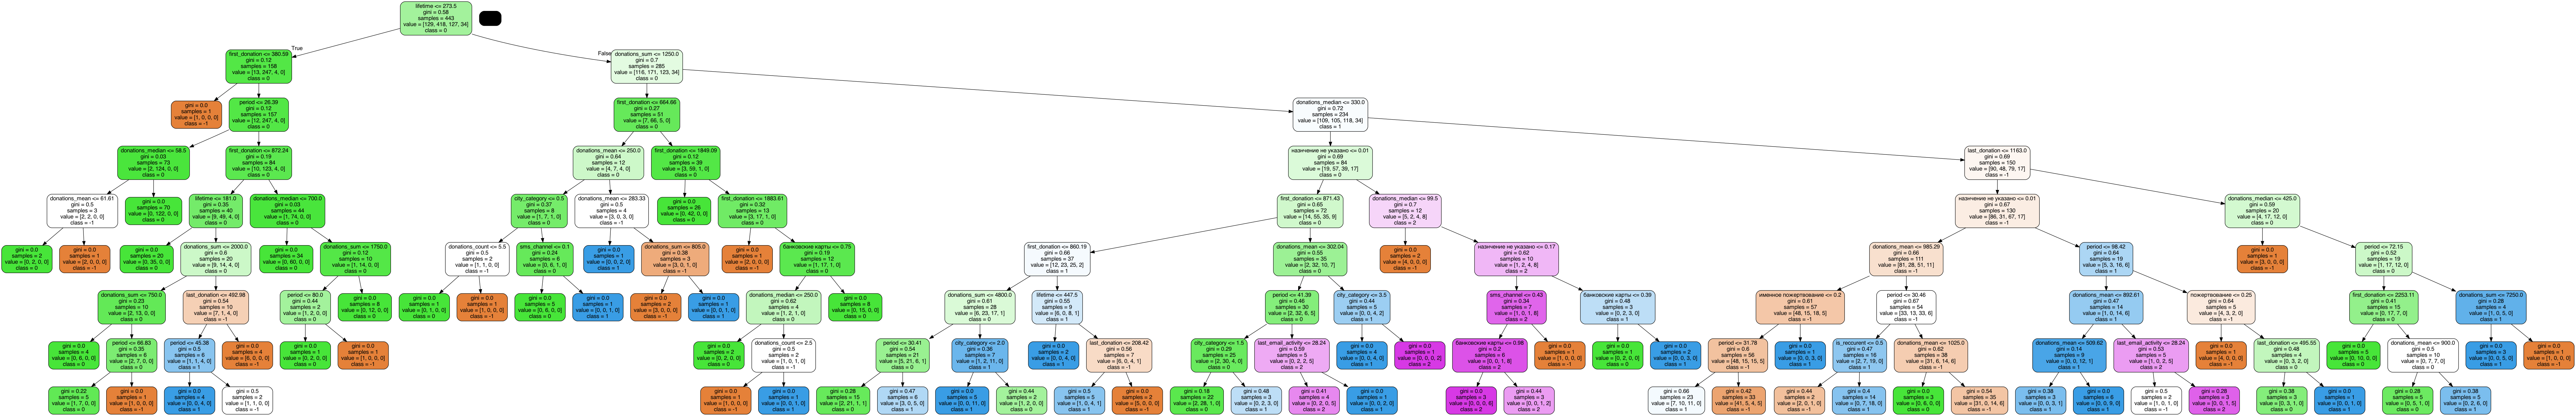

In [81]:
estimator = model3.estimators_[10]

export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = features_names,
                class_names = ['-1','0','1','2'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# конвертируем в png
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image(filename = 'tree.png')

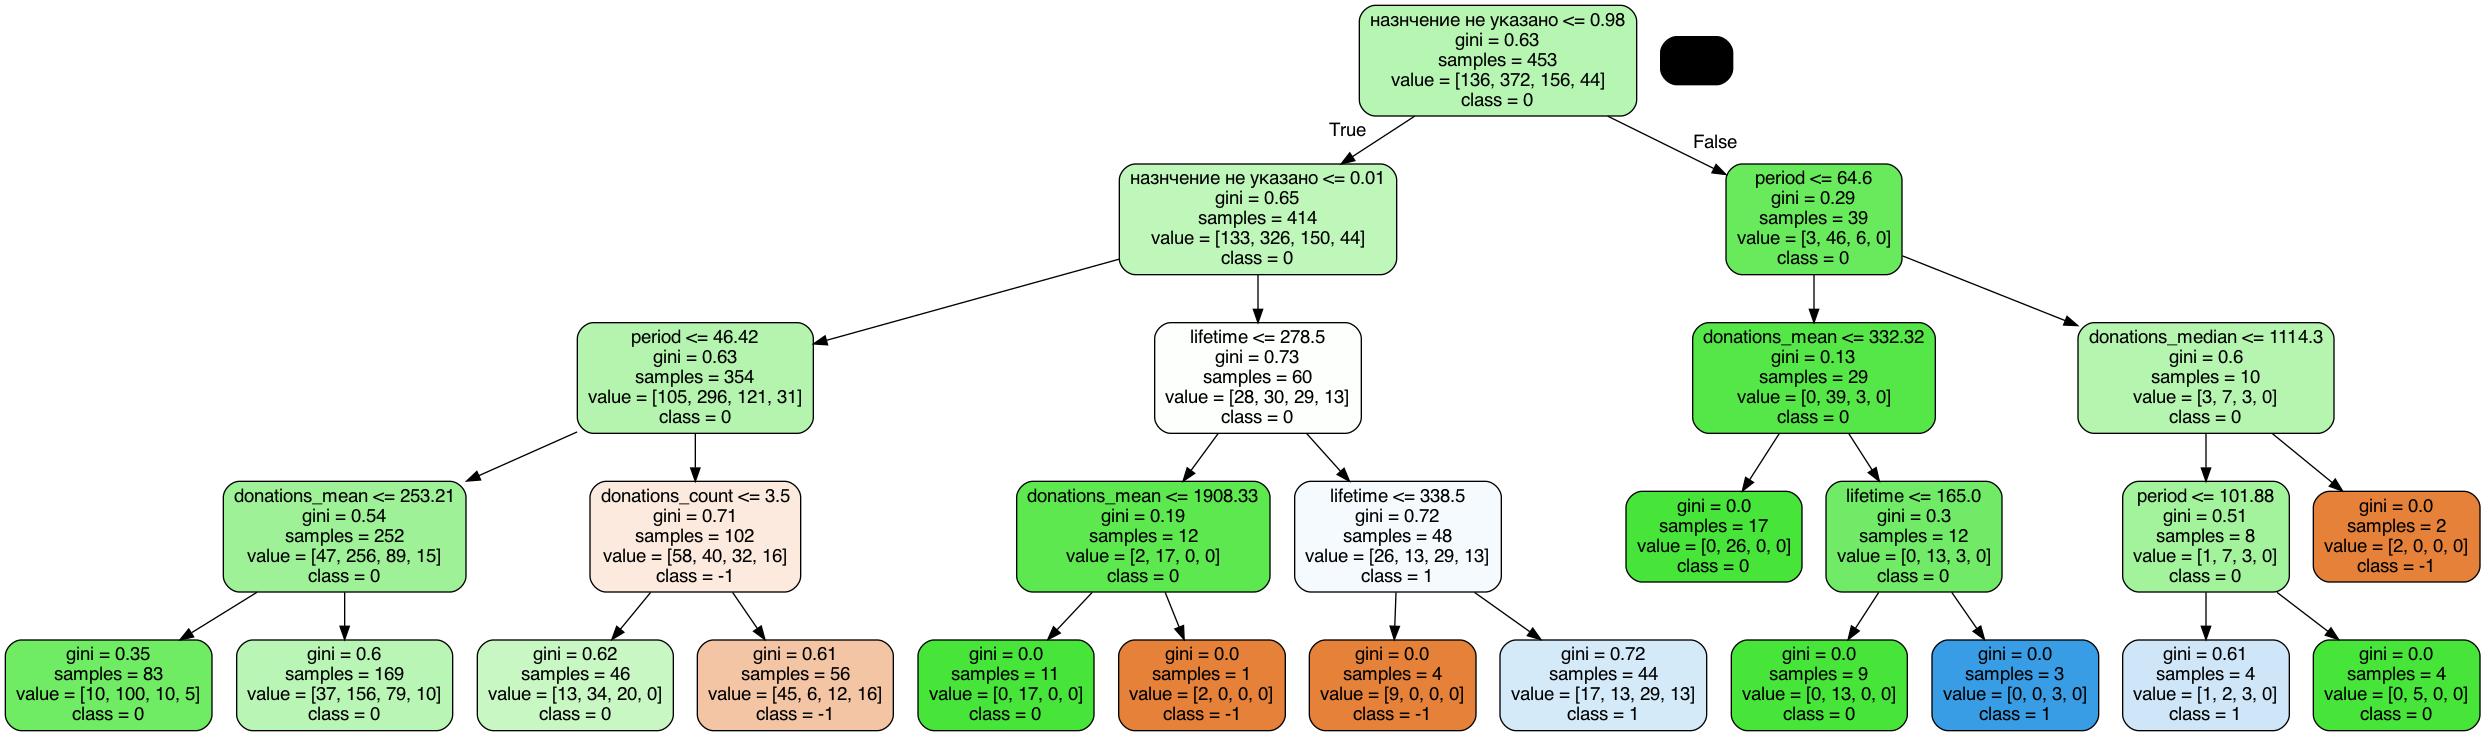

In [112]:
# пример небольшого дерева
model_10 = RandomForestClassifier(n_estimators=100, max_depth=4)
model_10.fit(features_train,target_train)
estimator_10 = model_10.estimators_[9]

export_graphviz(estimator_10, 
                out_file='tree_11.dot', 
                feature_names = features_train.columns,
                class_names = ['-1','0','1','2'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
(graph,) = pydot.graph_from_dot_file('tree_11.dot')
graph.write_png('tree_11.png')
Image(filename = 'tree_11.png', width=2000)